In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import optimize, stats

C:\Users\miche\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Patient of interest

In [2]:
# function to read in dataset 
def read_file(filename):
    df = pd.read_csv(filename)

    # Split the column into two new columns
    df[['TIMESTAMP', 'HRV']] = df['TIMESTAMP;HRV'].str.split(';', expand=True)

    # Convert TIMESTAMP & HRV to appropriate data types
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['HRV'] = pd.to_numeric(df['HRV'], errors='coerce')

    # Drop the original column
    df.drop(columns=['TIMESTAMP;HRV'], inplace=True)

    # Set TIMESTAMP as the index
    df.set_index('TIMESTAMP', inplace=True)

    return df

In [3]:
# read in patient one dataset
df_patient_hr = read_file('patient_hr_1.csv')
df_patient_hr

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:02.295,631.84
2009-03-04 11:00:02.927,624.02
2009-03-04 11:00:03.551,636.72
2009-03-04 11:00:04.188,625.98
...,...
2009-03-05 08:07:30.918,671.88
2009-03-05 08:07:31.590,669.92
2009-03-05 08:07:32.260,670.90


In [4]:
# check to make sure there are no null values
df_patient_hr.isnull().sum()

HRV    0
dtype: int64

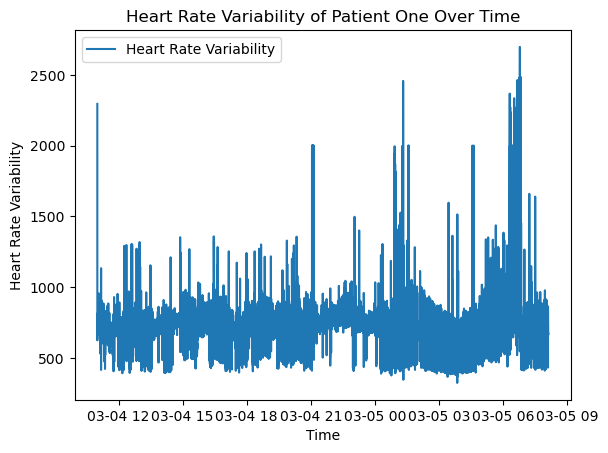

In [5]:
# visualize the time series
plt.plot(df_patient_hr['HRV'], label='Heart Rate Variability')
plt.xlabel('Time')
plt.ylabel('Heart Rate Variability')
plt.legend()
plt.title('Heart Rate Variability of Patient One Over Time')
plt.show();

In [6]:
# getting every 20 samples - downsampling because there are too many samples
df_downsampled = df_patient_hr.iloc[::20]
df_downsampled

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:15.000,723.63
2009-03-04 11:00:29.675,730.47
2009-03-04 11:00:45.161,775.39
2009-03-04 11:01:00.551,784.18
...,...
2009-03-05 08:06:29.501,668.95
2009-03-05 08:06:43.236,671.88
2009-03-05 08:06:56.870,639.65


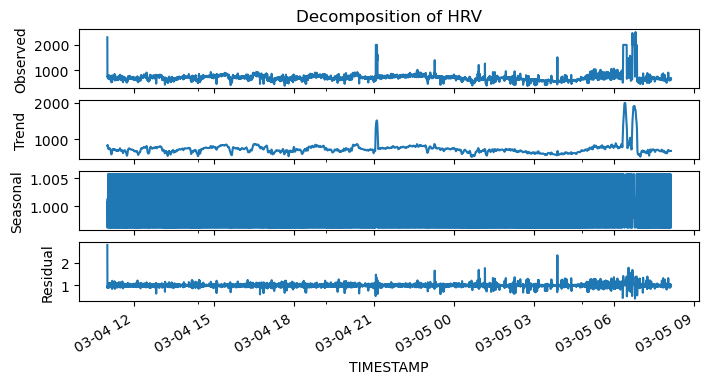

In [7]:
# checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
decomp1 = seasonal_decompose(df_downsampled['HRV'], period=10, model='multiplicative', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

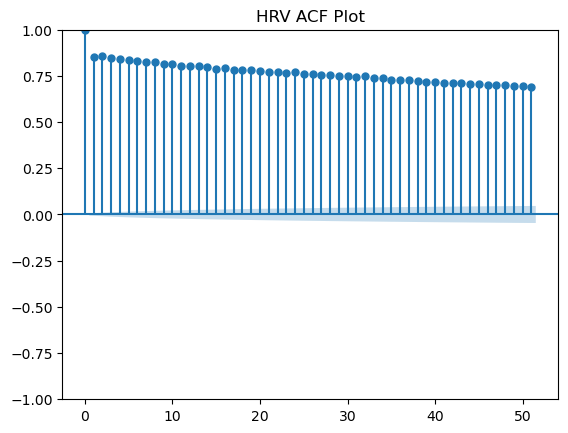

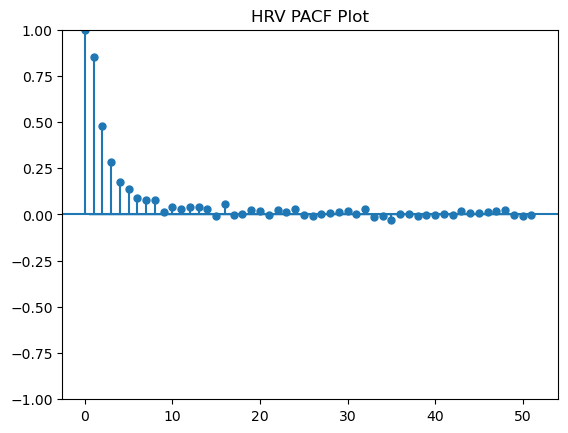

In [8]:
# plot of original dataset

# Autocorrelation Function
# This is used to determine the appropriate lag

series = df_patient_hr['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV PACF Plot')
plt.show();

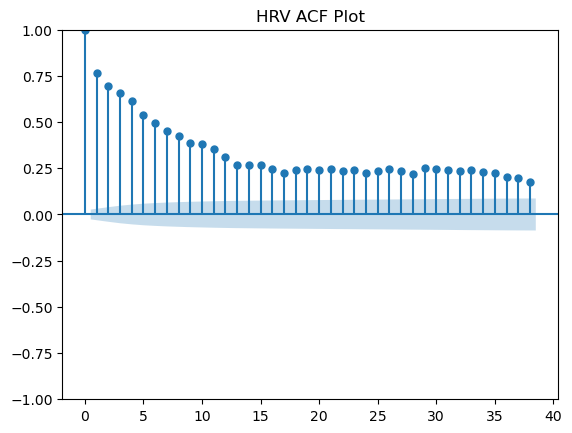

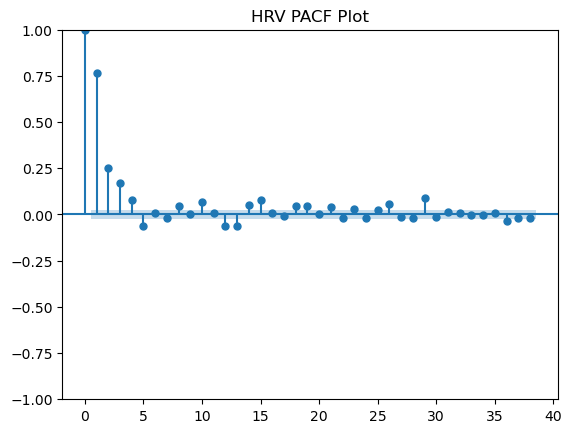

In [9]:
# plots of downsampled dataset

# Autocorrelation Function

series = df_downsampled['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV PACF Plot')
plt.show();

- AR model may be slightly better. This in the partial autocorrelation plot, it doesn't drop immediately.

# Create lag features for AR Model

In [10]:
# create lag features 1-100
for i in range(1, 101):
    df_downsampled[f'Lag {i}'] = df_downsampled['HRV'].shift(i)

df_downsampled = df_downsampled.dropna()

df_downsampled.head()

,HRV,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 91,Lag 92,Lag 93,Lag 94,Lag 95,Lag 96,Lag 97,Lag 98,Lag 99,Lag 100
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2009-03-04 11:23:17.894,645.51,697.27,725.59,722.66,650.39,619.14,619.14,662.11,673.83,738.28,...,678.71,742.19,800.78,772.46,757.81,784.18,775.39,730.47,723.63,2294.92
2009-03-04 11:23:30.812,710.94,645.51,697.27,725.59,722.66,650.39,619.14,619.14,662.11,673.83,...,708.98,678.71,742.19,800.78,772.46,757.81,784.18,775.39,730.47,723.63
2009-03-04 11:23:44.844,686.52,710.94,645.51,697.27,725.59,722.66,650.39,619.14,619.14,662.11,...,752.93,708.98,678.71,742.19,800.78,772.46,757.81,784.18,775.39,730.47
2009-03-04 11:23:59.019,692.38,686.52,710.94,645.51,697.27,725.59,722.66,650.39,619.14,619.14,...,778.32,752.93,708.98,678.71,742.19,800.78,772.46,757.81,784.18,775.39
2009-03-04 11:24:13.385,714.84,692.38,686.52,710.94,645.51,697.27,725.59,722.66,650.39,619.14,...,713.87,778.32,752.93,708.98,678.71,742.19,800.78,772.46,757.81,784.18


# Split data into training and testing set for AR Model

In [11]:
# split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
train_size = int(.8 * len(df_downsampled))
train_data = df_downsampled[:train_size]
test_data = df_downsampled[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# AR Model

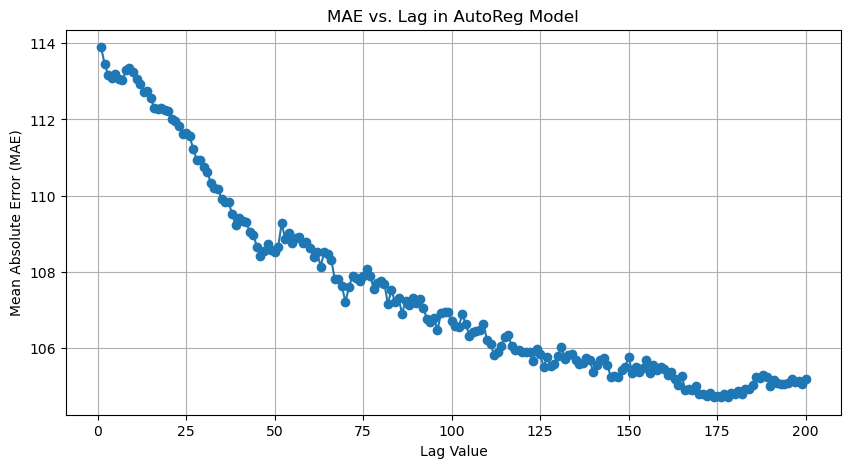

In [12]:
# define a range of lags to test
lag_values = range(1, 201)
mae_scores = []

# loop through different lag values
for lag in lag_values:
     # fit AR model with different lags
    ar_model = AutoReg(y_train, lags=lag, trend='c')
    ar_results = ar_model.fit()
    
    # make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # comptute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

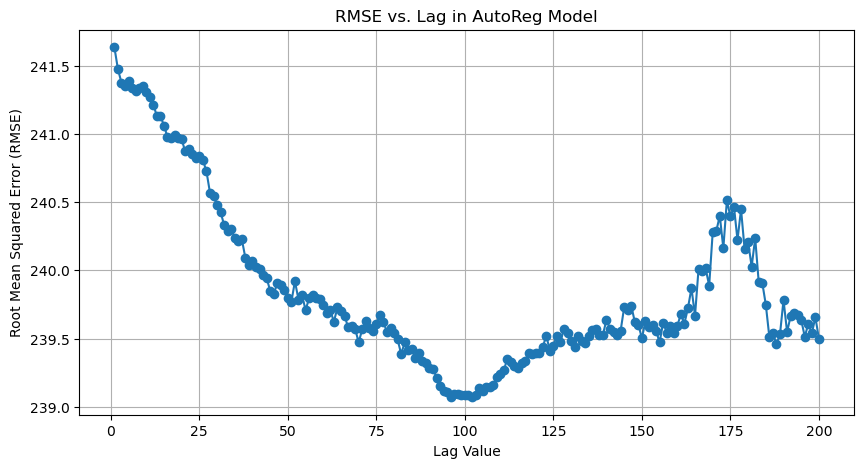

In [13]:
# define a range of lags to test
lag_values = range(1, 201)
rmse_scores = []

# loop through different lag values
for lag in lag_values:
    # fit AR model with different lags
    ar_model = AutoReg(y_train, lags=lag, trend='c')
    ar_results = ar_model.fit()
    
    # make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
     
    # compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)

# plot RMSE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

We will use lag value of 100 since the change in MAE and RMSE flattens out around lag value of 100.

## Manually

In [14]:
# lag chosen
lag = 100

# define X train
X_train = train_data.drop(columns=["HRV"])
X_train = np.column_stack((np.ones(len(X_train)), X_train))

# fit the model using OLS
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
print("Model coefficients:", w)

# initialize predictions
y_pred = []
last_vals = np.array(train_data['HRV'].iloc[-lag:].values[::-1])

# add constant term to last_vals for prediction
last_vals_with_const = np.concatenate([[1], last_vals])

for i in range(len(y_test)):
    # predict next value
    next_val = np.dot(last_vals_with_const, w)
    y_pred.append(next_val)
    
    # update last_vals
    last_vals = np.roll(last_vals, -1)
    last_vals[-1] = next_val
    last_vals_with_const = np.concatenate([[1], last_vals])

Model coefficients: [[ 4.06757367e+01]
 [ 4.67870279e-01]
 [ 2.30416915e-01]
 [ 1.04844663e-01]
 [ 2.81931310e-02]
 [-6.53880436e-02]
 [ 8.04927548e-03]
 [-5.59850229e-02]
 [ 1.51840448e-02]
 [ 6.16131206e-02]
 [ 1.47514489e-02]
 [ 6.36104439e-03]
 [-4.95767762e-03]
 [ 4.05688758e-02]
 [-3.62408250e-02]
 [ 1.26355247e-02]
 [ 4.81189601e-02]
 [ 3.68074045e-04]
 [-1.48525823e-02]
 [-1.60114124e-03]
 [-9.96043928e-03]
 [ 2.50356204e-02]
 [-1.56831086e-02]
 [ 3.51234751e-03]
 [ 1.68472517e-02]
 [-1.96468112e-02]
 [-1.12708232e-02]
 [ 9.96789404e-03]
 [ 3.03566201e-02]
 [-1.71252343e-02]
 [ 4.21759888e-03]
 [-1.33129420e-03]
 [ 1.91555896e-02]
 [ 4.29747436e-03]
 [-7.07655777e-03]
 [ 1.04128243e-02]
 [-1.17790639e-03]
 [-2.06075112e-02]
 [ 2.16502229e-02]
 [ 2.24885094e-02]
 [-1.49192613e-02]
 [ 4.70909151e-03]
 [-1.13042438e-02]
 [ 6.58328471e-03]
 [-4.20329625e-03]
 [ 1.45179934e-02]
 [ 1.90734954e-02]
 [-1.64588200e-02]
 [-5.90961503e-03]
 [ 9.92764074e-03]
 [ 1.13502969e-02]
 [ 3.863025

In [15]:
# function to find the roots to look at stationary assumption
def find_ar_roots(ar_coeffs):
    # Make sure ar_coeffs is 1D
    ar_coeffs_1d = ar_coeffs.flatten() if ar_coeffs.ndim > 1 else ar_coeffs
    
    # Create the polynomial coefficients (note the negative sign for AR coeffs)
    poly_coeffs = np.concatenate([[1], -1 * ar_coeffs_1d])
    
    # Find the roots
    roots = np.roots(poly_coeffs)
    
    return roots

# coefficients of the model
ar_coeffs = w[1:]

# roots of the model
roots = find_ar_roots(ar_coeffs)
print(abs(roots))

[0.99225027 0.9687101  0.9687101  0.96818614 0.96818614 0.96652345
 0.96652345 0.96694089 0.96694089 0.96556762 0.96556762 0.96990547
 0.96990547 0.94877005 0.94877005 0.97426894 0.97426894 0.96787034
 0.96787034 0.9676385  0.9676385  0.97173605 0.97173605 0.97555338
 0.97555338 0.96958633 0.96958633 0.96937351 0.96937351 0.96879373
 0.96879373 0.97550572 0.97550572 0.96650243 0.96650243 0.97424834
 0.97424834 0.97247084 0.97247084 0.96012866 0.96012866 0.96156511
 0.96156511 0.97789113 0.97789113 0.96986376 0.96986376 0.9767119
 0.9767119  0.97086892 0.97086892 0.97862548 0.98511231 0.98511231
 0.96862814 0.96862814 0.9645384  0.9645384  0.9803633  0.9803633
 0.97809458 0.97809458 0.95933925 0.95933925 0.96481804 0.96481804
 0.97690551 0.97690551 0.96891651 0.96891651 0.96805003 0.96805003
 0.98043613 0.98043613 0.95042134 0.95042134 0.97281468 0.97281468
 0.96809487 0.96809487 0.97304863 0.97304863 0.95692914 0.95692914
 0.96502348 0.96502348 0.96201714 0.96201714 0.95316449 0.953164

In [16]:
# put predictions into a data frame for plotting purposes
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
pred_data.set_index('Time', inplace=True)
pred_data.head()

,pred HRV
Time,
2009-03-05 03:53:31.930,[612.4554914652061]
2009-03-05 03:53:43.537,[529.2844947004]
2009-03-05 03:53:55.465,[563.3532951012846]
2009-03-05 03:54:07.439,[527.5769656316976]
2009-03-05 03:54:18.885,[583.6095101186505]


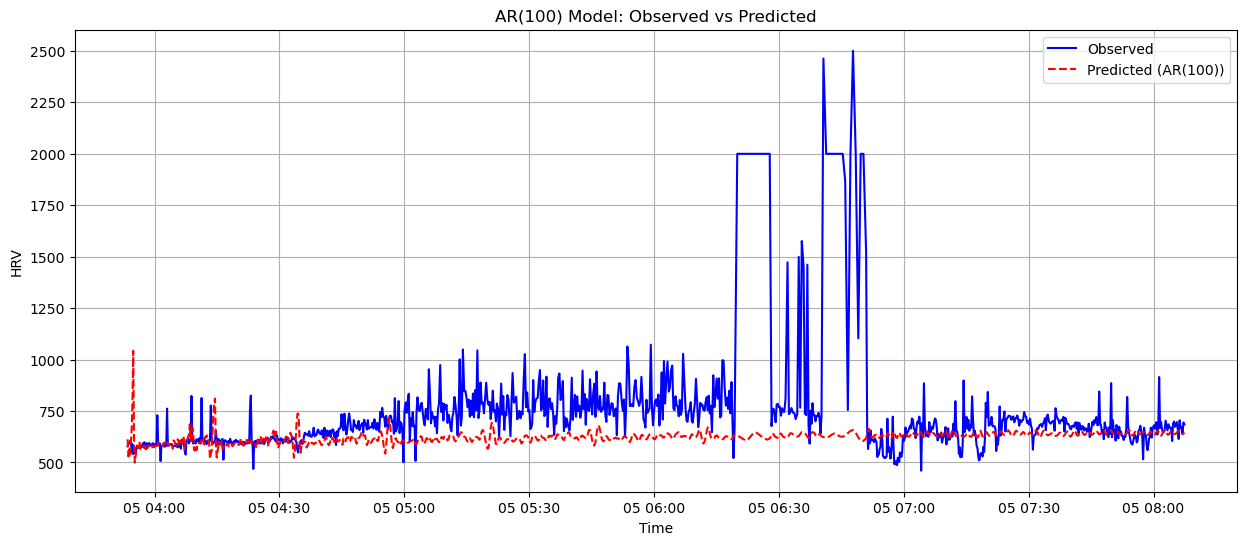

In [17]:
# plot observed versus predicted
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (AR(100))')
plt.legend()
plt.title('AR(100) Model: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [18]:
# compute mae and rmse
mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 122.44
Root Mean Squared Error: 261.48


# Create order features for MA model

In [19]:
# getting every 20 samples - downsampling because there are too many samples
df_downsampled = df_patient_hr.iloc[::20]
df_downsampled

# get order features 1-28
for i in range(1, 29):
    df_downsampled[f'Order {i}'] = df_downsampled['HRV'].shift(i)

df_downsampled = df_downsampled.dropna()

df_downsampled.head()

,HRV,Order 1,Order 2,Order 3,Order 4,Order 5,Order 6,Order 7,Order 8,Order 9,...,Order 19,Order 20,Order 21,Order 22,Order 23,Order 24,Order 25,Order 26,Order 27,Order 28
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2009-03-04 11:06:55.880,736.33,710.94,774.41,744.14,723.63,731.45,762.70,685.55,731.45,807.62,...,678.71,742.19,800.78,772.46,757.81,784.18,775.39,730.47,723.63,2294.92
2009-03-04 11:07:10.391,777.34,736.33,710.94,774.41,744.14,723.63,731.45,762.70,685.55,731.45,...,708.98,678.71,742.19,800.78,772.46,757.81,784.18,775.39,730.47,723.63
2009-03-04 11:07:24.704,700.20,777.34,736.33,710.94,774.41,744.14,723.63,731.45,762.70,685.55,...,752.93,708.98,678.71,742.19,800.78,772.46,757.81,784.18,775.39,730.47
2009-03-04 11:07:38.454,647.46,700.20,777.34,736.33,710.94,774.41,744.14,723.63,731.45,762.70,...,778.32,752.93,708.98,678.71,742.19,800.78,772.46,757.81,784.18,775.39
2009-03-04 11:07:50.729,593.75,647.46,700.20,777.34,736.33,710.94,774.41,744.14,723.63,731.45,...,713.87,778.32,752.93,708.98,678.71,742.19,800.78,772.46,757.81,784.18


# Split data into training and testing set for MA Model

In [20]:
# split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
train_size = int(.8 * len(df_downsampled))
train_data = df_downsampled[:train_size]
test_data = df_downsampled[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# MA model

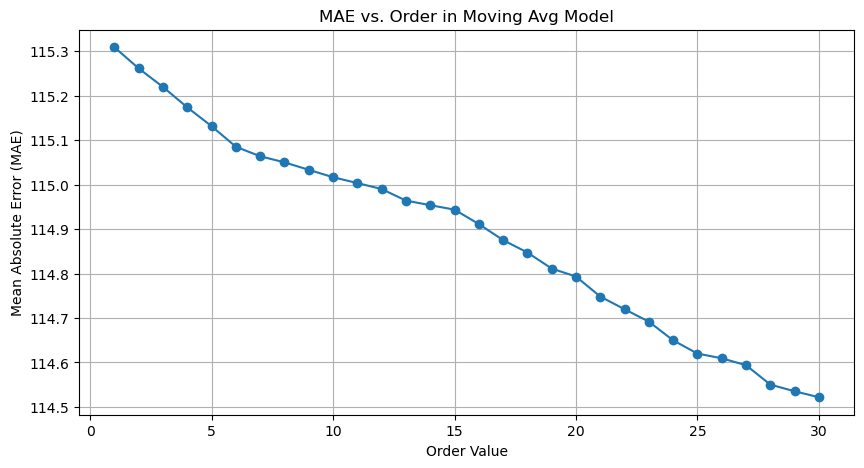

In [21]:
# define a range of orders to test
o_values = range(1, 31)
mae_scores = []

# loop through different order values
for o in o_values:
    ma_model = ARIMA(y_train, order=(0,0,o))
    ma_results = ma_model.fit()
    
    # make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

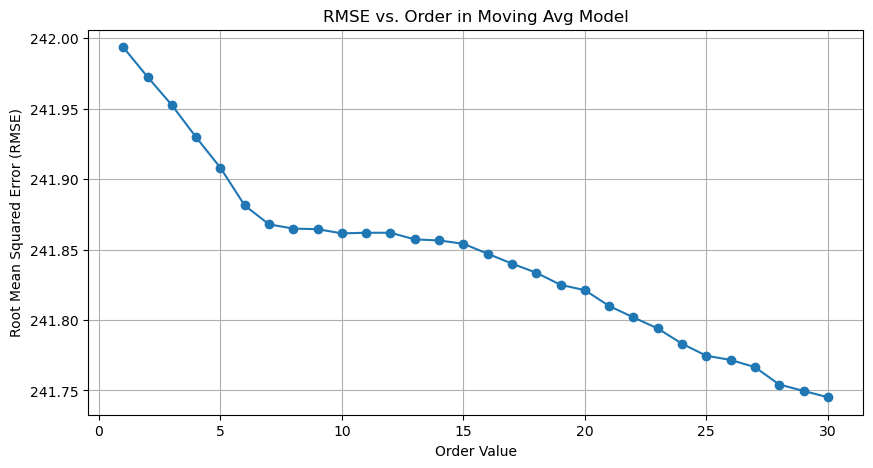

In [22]:
# define a range of orders to test
o_values = range(1, 31)
rmse_scores = []

# loop through different order values
for o in o_values:
    ma_model = ARIMA(y_train, order=(0,0,o))
    ma_results = ma_model.fit()
    
    # make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute rmse
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)


# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

## Manually

In [23]:
# calculate the error terms (residuals)
def ma_errors(params, y, q):
    """
    Calculate residuals for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    # define variables
    intercept = params[0]  
    theta = params[1:]  
    n = len(y)
    errors = np.zeros(n)
    
    # initialize past errors
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # make prediction
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
        
    return errors

# calculate the log-likelihood for MA(q) model
def ma_log_likelihood(params, y, q):
    """
    Calculate the log-likelihood for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    # define variables
    intercept = params[0]
    theta = params[1:]
    n = len(y)
    errors = np.zeros(n)
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # make prediction
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
    
    # calculate log-likelihood (assuming errors are normally distributed)
    sigma2 = np.var(errors)  # Estimate of error variance
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(errors**2) / sigma2
    
    return -log_likelihood

# fit MA model using MLE
def fit_ma_mle(y_train, q):
    """
    Fit MA(q) model with intercept using Maximum Likelihood Estimation
    y_train: training data for y
    q: order of the model
    """
    # initialize parameters (intercept and theta parameters)
    initial_intercept = np.mean(y_train)
    initial_theta = np.zeros(q)
    initial_params = np.concatenate(([initial_intercept], initial_theta))
    
    # use optimization to find the best parameters
    result = optimize.minimize(ma_log_likelihood, initial_params, args=(y_train, q,), 
                             method='L-BFGS-B')
    return result.x

# predict using MA model
def predict_ma(params, y_test_len, training_errors, q):
    """
    Make predictions using MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters
    y_test_len: number of steps to predict
    training_errors: last q error terms from training data
    q: order of the model
    """
    # define intercept and theta
    intercept = params[0]
    theta = params[1:]
    
    # initialize predictions array
    predictions = np.zeros(y_test_len)
    # start with last q error terms from training
    past_errors = np.array(training_errors[:q])
    
    for t in range(y_test_len):
        # predictions
        predictions[t] = intercept + np.sum(theta * past_errors)
        new_error = 0
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = new_error
        
    return predictions

# fit MA(q) and make predictions
def run_ma_model_mle(train_data, test_data, q):
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV'])
    
    # fit MA(q) model with intercept using MLE
    params = fit_ma_mle(y_train, q)
    intercept = params[0]
    theta = params[1:]
    
    # print coefficients
    print("Coefficients:")
    print(f"Intercept: {intercept:.6f}")
    for i, coef in enumerate(theta):
        print(f"MA({i+1}): {coef:.6f}")
    
    # calculate errors from training data
    training_errors = ma_errors(params, y_train, q)
    
    # make predictions
    y_pred = predict_ma(params, len(test_data), training_errors, q)
    
    # put predictions into dataframe format
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    return pred_data, params

In [24]:
# order chosen
order = 28

# run ma model
pred_data, theta = run_ma_model_mle(train_data, test_data, order)
pred_data.head()

Coefficients:
Intercept: 703.663272
MA(1): 0.487800
MA(2): 0.497304
MA(3): 0.469059
MA(4): 0.435450
MA(5): 0.322095
MA(6): 0.301487
MA(7): 0.198303
MA(8): 0.180427
MA(9): 0.192516
MA(10): 0.179401
MA(11): 0.165649
MA(12): 0.163080
MA(13): 0.187443
MA(14): 0.145870
MA(15): 0.156470
MA(16): 0.184997
MA(17): 0.168498
MA(18): 0.145516
MA(19): 0.146671
MA(20): 0.118228
MA(21): 0.133598
MA(22): 0.101258
MA(23): 0.089421
MA(24): 0.091962
MA(25): 0.058795
MA(26): 0.038554
MA(27): 0.034795
MA(28): 0.042318


,pred HRV
Time,
2009-03-05 03:50:44.221,642.375808
2009-03-05 03:50:55.460,651.919407
2009-03-05 03:51:06.578,655.299753
2009-03-05 03:51:17.431,662.649292
2009-03-05 03:51:29.434,660.848345


In [25]:
# function to get roots for ma model
def find_ma_roots(ma_coeffs):
    # create the polynomial coefficients (note the negative sign for MA coeffs)
    poly_coeffs = np.concatenate([[1], -1 * ma_coeffs])
    
    # find the roots
    roots = np.roots(poly_coeffs)
    
    return roots

# coefficients of the ma model
ma_coeffs = theta[1:]

# roots of the ma model
roots = find_ma_roots(ma_coeffs)
print(abs(roots))

[1.42354584 0.939016   0.939016   0.87797692 0.87797692 0.86412738
 0.86412738 0.85224104 0.85224104 0.87983557 0.87983557 0.87402565
 0.87402565 0.88782911 0.88782911 0.88714962 0.88714962 0.89045128
 0.89045128 0.86331019 0.88236125 0.88236125 0.87561816 0.87561816
 0.86221405 0.86221405 0.85066779 0.85066779]


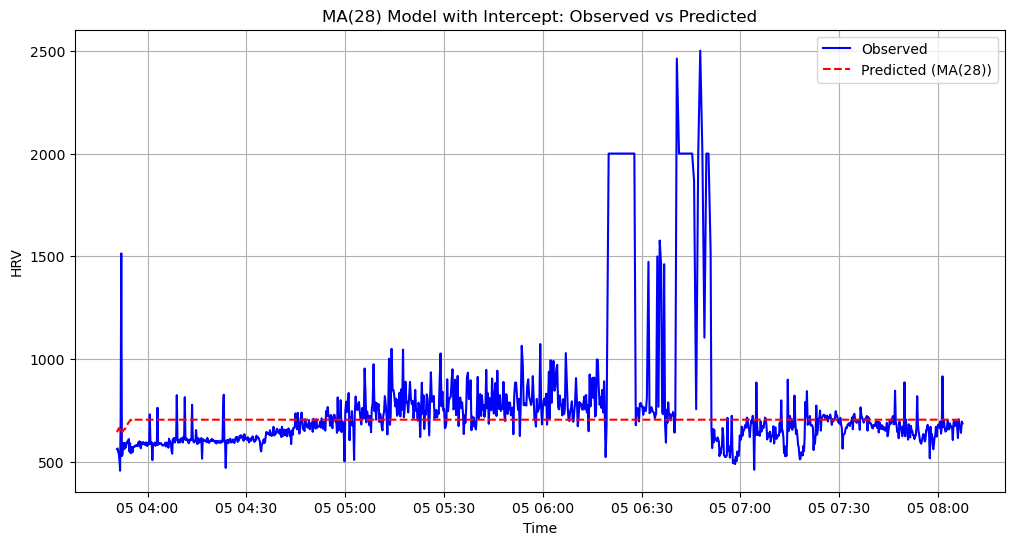

In [26]:
# plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (MA(28))')
plt.legend()
plt.title('MA(28) Model with Intercept: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [27]:
# compute mae and rmse
mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 114.75
Root Mean Squared Error: 241.82
